In [ ]:
# TODO : REPLACE n_samples PAR size_test DANS LES TESTS

# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.optimize import Bounds

from scipy.stats import ttest_ind

In [3]:
from prettytable import PrettyTable

In [4]:
plt.rcParams.update({
    "text.usetex": True
})

In [5]:
import dirichlet_regression

In [6]:
from scipy.optimize import fmin, newton, minimize

In [7]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [8]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,[rho_derivative]]))

In [9]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [10]:
def fprime_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [11]:
def create_features_matrices(n_samples,n_features,choice_W='X_dependent',threshold_neighbors=0.3,nneighbors=5):
    X = np.random.uniform(size=(n_samples,n_features))
    X = (X-X.min())/(X.max()-X.min())
    X = np.array([np.concatenate(([1],x)) for x in X])
    Z = np.random.uniform(size=(n_samples,n_features))
    
    if choice_W == 'random':
        neighbors = NearestNeighbors(n_neighbors=nneighbors).fit(np.arange(n_samples).reshape(-1,1))
        W = neighbors.kneighbors_graph(np.arange(n_samples).reshape(-1,1)).toarray()
    else:
        distance_matrix = scipy.spatial.distance_matrix(X,X)
        W = np.zeros(np.shape(distance_matrix))
        W[distance_matrix < threshold_neighbors] = 1
    # replace the 1 on the diagonal by 0
    np.fill_diagonal(W,0)
    # scaling the matrix, so that the sum of each row is 1
    W = W/W.sum(axis=1)[:,None]
    return(X,Z,W)

# With two features

In [12]:
n_features = 2
n_classes = 3

In [13]:
np.random.seed(21)

beta = np.array([[0.  , -1.6 , 1.],
                 [0.  , 1.8, -1.4],
                 [0.  , 1.4, -1.1 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

In [14]:
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = [0.,0.]
rho0 = [0.]
params0_spatial = np.concatenate([beta0.flatten(),gamma0, rho0])
params0_no_spatial = np.concatenate([beta0.flatten(),gamma0])

min_bounds_1 = -np.inf*np.ones(len(params0_spatial)) 
max_bounds_1 = np.inf*np.ones(len(params0_spatial))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [15]:
X,Z,W = create_features_matrices(50,n_features,threshold_neighbors=0.3)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

10.72

In [16]:
X,Z,W = create_features_matrices(200,n_features,threshold_neighbors=0.14)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

9.95

In [17]:
X,Z,W = create_features_matrices(1000,n_features,threshold_neighbors=0.06)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

10.772

## rho=0.5

In [18]:
rho = 0.5

In [27]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbet

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_m

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 28min 19s


In [30]:
np.save('Data Dirichlet/spatial_rho05_2.npy',list_solutions_spatial)

In [31]:
np.save('Data Dirichlet/no_spatial_rho05_2.npy',list_solutions_no_spatial)

In [61]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho05_2.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho05_2.npy',allow_pickle=True)

In [62]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 1min 1s


In [63]:
np.save('Data Dirichlet/list_r2_s_rho05_2.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho05_2.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho05_2.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho05_2.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho05_2.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho05_2.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho05_2.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho05_2.npy', list_crossentropy_ns)

In [35]:
list_r2_s_rho05 = list_r2_s
list_rmse_s_rho05 = list_rmse_s
list_ll_s_rho05 = list_ll_s
list_crossentropy_s_rho05 = list_crossentropy_s
list_r2_ns_rho05 = list_r2_ns
list_rmse_ns_rho05 = list_rmse_ns
list_ll_ns_rho05 = list_ll_ns
list_crossentropy_ns_rho05 = list_crossentropy_ns

## rho = 0.9

In [44]:
rho = 0.9

In [45]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 26min 36s


In [46]:
np.save('Data Dirichlet/spatial_rho09_2.npy',list_solutions_spatial)
np.save('Data Dirichlet/no_spatial_rho09_2.npy',list_solutions_no_spatial)

In [58]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho09_2.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho09_2.npy',allow_pickle=True)

In [59]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 48 s


In [60]:
np.save('Data Dirichlet/list_r2_s_rho09_2.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho09_2.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho09_2.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho09_2.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho09_2.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho09_2.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho09_2.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho09_2.npy', list_crossentropy_ns)

In [49]:
np.mean(list_r2_s[1])

0.2819441854425965

In [50]:
np.mean(list_r2_ns[1])

0.18115353811993798

## rho = 0.1

In [51]:
rho = 0.1

In [52]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 16min 40s


In [147]:
np.mean(np.array(list_solutions_spatial[2])[:,-1])

0.12334254778812988

In [53]:
np.save('Data Dirichlet/spatial_rho01_2.npy',list_solutions_spatial)
np.save('Data Dirichlet/no_spatial_rho01_2.npy',list_solutions_no_spatial)

In [16]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho01_2.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho01_2.npy',allow_pickle=True)

In [54]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 43.3 s
Parser   : 563 ms


In [55]:
np.save('Data Dirichlet/list_r2_s_rho01_2.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho01_2.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho01_2.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho01_2.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho01_2.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho01_2.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho01_2.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho01_2.npy', list_crossentropy_ns)

In [56]:
np.mean(list_r2_s[2])

0.1404785522315651

In [57]:
np.mean(list_r2_ns[2])

0.14005293559945395

## rho=0

In [16]:
rho = 0.

In [17]:
%%time

n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 17min 50s


In [18]:
np.save('Data Dirichlet/spatial_rho00_2.npy',list_solutions_spatial)
np.save('Data Dirichlet/no_spatial_rho00_2.npy',list_solutions_no_spatial)

In [19]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho00_2.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho00_2.npy',allow_pickle=True)

# RESULTS

In [20]:
list_solutions_spatial_rho01 = np.load('Data Dirichlet/spatial_rho01_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho01 = np.load('Data Dirichlet/no_spatial_rho01_2.npy',allow_pickle=True)

list_solutions_spatial_rho05 = np.load('Data Dirichlet/spatial_rho05_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho05 = np.load('Data Dirichlet/no_spatial_rho05_2.npy',allow_pickle=True)

list_solutions_spatial_rho09 = np.load('Data Dirichlet/spatial_rho09_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho09 = np.load('Data Dirichlet/no_spatial_rho09_2.npy',allow_pickle=True)

list_solutions_spatial_rho00 = np.load('Data Dirichlet/spatial_rho00_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho00 = np.load('Data Dirichlet/no_spatial_rho00_2.npy',allow_pickle=True)

In [14]:
list_r2_s_rho01 = np.load('Data Dirichlet/list_r2_s_rho01_2.npy', allow_pickle=True)
list_rmse_s_rho01 = np.load('Data Dirichlet/list_rmse_s_rho01_2.npy', allow_pickle=True)
list_ll_s_rho01 = np.load('Data Dirichlet/list_ll_s_rho01_2.npy', allow_pickle=True)
list_crossentropy_s_rho01 = np.load('Data Dirichlet/list_crossentropy_s_rho01_2.npy', allow_pickle=True)
list_r2_ns_rho01 = np.load('Data Dirichlet/list_r2_ns_rho01_2.npy', allow_pickle=True)
list_rmse_ns_rho01 = np.load('Data Dirichlet/list_rmse_ns_rho01_2.npy', allow_pickle=True)
list_ll_ns_rho01 = np.load('Data Dirichlet/list_ll_ns_rho01_2.npy', allow_pickle=True)
list_crossentropy_ns_rho01 = np.load('Data Dirichlet/list_crossentropy_ns_rho01_2.npy', allow_pickle=True)

In [15]:
list_r2_s_rho05 = np.load('Data Dirichlet/list_r2_s_rho05_2.npy', allow_pickle=True)
list_rmse_s_rho05 = np.load('Data Dirichlet/list_rmse_s_rho05_2.npy', allow_pickle=True)
list_ll_s_rho05 = np.load('Data Dirichlet/list_ll_s_rho05_2.npy', allow_pickle=True)
list_crossentropy_s_rho05 = np.load('Data Dirichlet/list_crossentropy_s_rho05_2.npy', allow_pickle=True)
list_r2_ns_rho05 = np.load('Data Dirichlet/list_r2_ns_rho05_2.npy', allow_pickle=True)
list_rmse_ns_rho05 = np.load('Data Dirichlet/list_rmse_ns_rho05_2.npy', allow_pickle=True)
list_ll_ns_rho05 = np.load('Data Dirichlet/list_ll_ns_rho05_2.npy', allow_pickle=True)
list_crossentropy_ns_rho05 = np.load('Data Dirichlet/list_crossentropy_ns_rho05_2.npy', allow_pickle=True)

In [16]:
list_r2_s_rho09 = np.load('Data Dirichlet/list_r2_s_rho09_2.npy', allow_pickle=True)
list_rmse_s_rho09 = np.load('Data Dirichlet/list_rmse_s_rho09_2.npy', allow_pickle=True)
list_ll_s_rho09 = np.load('Data Dirichlet/list_ll_s_rho09_2.npy', allow_pickle=True)
list_crossentropy_s_rho09 = np.load('Data Dirichlet/list_crossentropy_s_rho09_2.npy', allow_pickle=True)
list_r2_ns_rho09 = np.load('Data Dirichlet/list_r2_ns_rho09_2.npy', allow_pickle=True)
list_rmse_ns_rho09 = np.load('Data Dirichlet/list_rmse_ns_rho09_2.npy', allow_pickle=True)
list_ll_ns_rho09 = np.load('Data Dirichlet/list_ll_ns_rho09_2.npy', allow_pickle=True)
list_crossentropy_ns_rho09 = np.load('Data Dirichlet/list_crossentropy_ns_rho09_2.npy', allow_pickle=True)

In [21]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho00[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho00[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho00[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho00[i],axis=0))

In [22]:
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['Parameter','beta_00','beta_01','beta_02','beta_10','beta_11','beta_12','beta_20','beta_21','beta_22','gamma_0','gamma_1','rho']

pt = PrettyTable(rows_names)
pt.title = 'PARAMETERS WITH SPATIAL (rho=0, 100 repetitions)'

for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_s[i],3)]))
for i in range(len(list_results_var_s)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_s[i],3)]))
for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3)]))

for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_ns[i],3),['-']]))
for i in range(len(list_results_var_ns)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_ns[i],3),['-']]))
for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3),['-']]))
    
pt.del_column('beta_00')
pt.del_column('beta_10')
pt.del_column('beta_20')
print(pt)

+--------------------------------------------------------------------------------------------------------+
|                            PARAMETERS WITH SPATIAL (rho=0, 100 repetitions)                            |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|   Parameter   | beta_01 | beta_02 | beta_11 | beta_12 | beta_21 | beta_22 | gamma_0 | gamma_1 |  rho   |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|  Bias (n=50)  |  0.639  |  -0.43  |  -0.607 |  0.652  |  -0.49  |  0.534  |  0.475  |  0.495  | -0.125 |
|  Bias (n=200) |  0.554  |  -0.401 |  -0.55  |  0.617  |  -0.432 |  0.475  |  0.259  |   0.3   | -0.02  |
| Bias (n=1000) |  0.475  |  -0.326 |  -0.467 |  0.493  |  -0.363 |  0.422  |  0.161  |  0.186  | -0.007 |
|   Var (n=50)  |  0.175  |  0.143  |  0.291  |  0.214  |  0.262  |  0.153  |  0.056  |  0.053  | 0.217  |
|  Var (n=200)  |  0.042  |  0.053  |

In [74]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.1]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho01[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho01[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho01[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho01[i],axis=0))

In [75]:
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['Parameter','beta_00','beta_01','beta_02','beta_10','beta_11','beta_12','beta_20','beta_21','beta_22','gamma_0','gamma_1','rho']

pt = PrettyTable(rows_names)
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)'

for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_s[i],3)]))
for i in range(len(list_results_var_s)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_s[i],3)]))
for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3)]))

for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_ns[i],3),['-']]))
for i in range(len(list_results_var_ns)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_ns[i],3),['-']]))
for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3),['-']]))
    
pt.del_column('beta_00')
pt.del_column('beta_10')
pt.del_column('beta_20')
print(pt)

+--------------------------------------------------------------------------------------------------------+
|                           PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)                           |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|   Parameter   | beta_01 | beta_02 | beta_11 | beta_12 | beta_21 | beta_22 | gamma_0 | gamma_1 |  rho   |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|  Bias (n=50)  |  0.603  |  -0.465 |  -0.601 |  0.657  |  -0.475 |  0.572  |   0.48  |  0.496  | -0.11  |
|  Bias (n=200) |  0.541  |  -0.423 |  -0.554 |   0.62  |  -0.421 |  0.498  |  0.262  |  0.297  | -0.009 |
| Bias (n=1000) |  0.476  |  -0.324 |  -0.474 |  0.492  |  -0.373 |  0.408  |  0.163  |  0.184  |  0.0   |
|   Var (n=50)  |  0.164  |  0.169  |   0.29  |  0.233  |  0.317  |  0.201  |  0.049  |  0.046  | 0.202  |
|  Var (n=200)  |  0.034  |  0.047  |

In [71]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.5]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho05[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho05[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho05[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho05[i],axis=0))

In [72]:
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['Parameter','beta_00','beta_01','beta_02','beta_10','beta_11','beta_12','beta_20','beta_21','beta_22','gamma_0','gamma_1','rho']

pt = PrettyTable(rows_names)
pt.title = 'PARAMETERS(rho=0.5, 100 repetitions)'

for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_s[i],3)]))
for i in range(len(list_results_var_s)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_s[i],3)]))
for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3)]))

for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_ns[i],3),['-']]))
for i in range(len(list_results_var_ns)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_ns[i],3),['-']]))
for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3),['-']]))
    
pt.del_column('beta_00')
pt.del_column('beta_10')
pt.del_column('beta_20')
print(pt)

+--------------------------------------------------------------------------------------------------------+
|                                  PARAMETERS(rho=0.5, 100 repetitions)                                  |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|   Parameter   | beta_01 | beta_02 | beta_11 | beta_12 | beta_21 | beta_22 | gamma_0 | gamma_1 |  rho   |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|  Bias (n=50)  |  0.567  |  -0.57  |  -0.554 |  0.752  |  -0.485 |  0.585  |  0.491  |   0.49  | -0.174 |
|  Bias (n=200) |  0.544  |  -0.494 |  -0.54  |  0.653  |  -0.445 |  0.552  |  0.267  |  0.292  | -0.113 |
| Bias (n=1000) |  0.479  |  -0.461 |  -0.489 |  0.567  |  -0.399 |  0.461  |  0.166  |  0.179  | -0.167 |
|   Var (n=50)  |  0.158  |  0.155  |  0.258  |  0.255  |  0.281  |  0.236  |  0.061  |  0.058  | 0.108  |
|  Var (n=200)  |  0.029  |  0.029  |

In [79]:
np.shape(list_solutions_spatial_rho09)

(3, 100, 12)

In [73]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.9]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho09[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho09[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho09[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho09[i],axis=0))

In [70]:
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['Parameter','beta_00','beta_01','beta_02','beta_10','beta_11','beta_12','beta_20','beta_21','beta_22','gamma_0','gamma_1','rho']

pt = PrettyTable(rows_names)
pt.title = 'PARAMETERS(rho=0.9, 100 repetitions)'

for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_s[i],3)]))
for i in range(len(list_results_var_s)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_s[i],3)]))
for i in range(len(list_results_bias_s)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3)]))

for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+1]],np.round(list_results_bias_ns[i],3),['-']]))
for i in range(len(list_results_var_ns)):
    pt.add_row(np.concatenate([[columns_names[i+4]],np.round(list_results_var_ns[i],3),['-']]))
for i in range(len(list_results_bias_ns)):
    pt.add_row(np.concatenate([[columns_names[i+7]],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3),['-']]))
    
pt.del_column('beta_00')
pt.del_column('beta_10')
pt.del_column('beta_20')
print(pt)

+--------------------------------------------------------------------------------------------------------+
|                                  PARAMETERS(rho=0.9, 100 repetitions)                                  |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|   Parameter   | beta_01 | beta_02 | beta_11 | beta_12 | beta_21 | beta_22 | gamma_0 | gamma_1 |  rho   |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|  Bias (n=50)  |  0.407  |  -1.158 |  -0.487 |  1.198  |   -0.4  |  0.958  |  0.474  |  0.491  | -0.348 |
|  Bias (n=200) |  0.335  |  -1.214 |  -0.239 |  1.154  |  -0.362 |  0.846  |  0.186  |  0.206  | -0.51  |
| Bias (n=1000) |   0.1   |  -1.226 |  -0.068 |   0.95  |  -0.236 |  0.753  |  0.032  |  0.059  | -0.652 |
|   Var (n=50)  |   0.19  |  0.228  |   0.33  |  0.375  |  0.349  |  0.287  |  0.109  |  0.112  | 0.072  |
|  Var (n=200)  |  0.133  |  0.063  |

# Analysis of rho 0.9

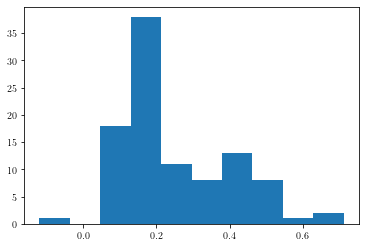

In [20]:
plt.hist(list_solutions_spatial_rho09[2,:,-1])
plt.show()

In [47]:
rho=0.9
n_samples=200
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [48]:
list_ll_200 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_200.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

In [49]:
rho=0.9
n_samples=500
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [50]:
list_ll_500 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_500.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

In [58]:
rho=0.9
n_samples=1000
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [59]:
list_ll_1000 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_1000.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

In [35]:
rho=0.9
n_samples=2000
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [36]:
list_ll_2000 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_2000.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

In [31]:
rho=0.9
n_samples=5000
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [32]:
list_ll_5000 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_5000.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

In [39]:
rho=0.9
n_samples=10000
X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [40]:
list_ll_10000 = []
for rho_temp in np.arange(-0.2,1.,0.1):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_10000.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))

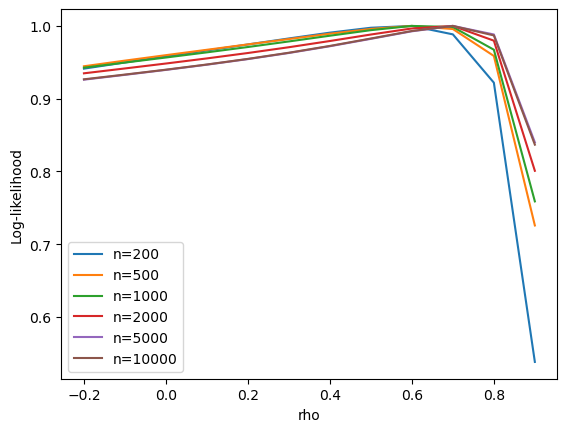

In [60]:
plt.plot(np.arange(-0.2,1.,0.1),list_ll_200/np.max(list_ll_200),label='n=200')
plt.plot(np.arange(-0.2,1.,0.1),list_ll_500/np.max(list_ll_500),label='n=500')
plt.plot(np.arange(-0.2,1.,0.1),list_ll_1000/np.max(list_ll_1000),label='n=1000')
plt.plot(np.arange(-0.2,1.,0.1),list_ll_2000/np.max(list_ll_2000),label='n=2000')
plt.plot(np.arange(-0.2,1.,0.1),list_ll_5000/np.max(list_ll_5000),label='n=5000')
plt.plot(np.arange(-0.2,1.,0.1),list_ll_10000/np.max(list_ll_10000),label='n=10000')
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

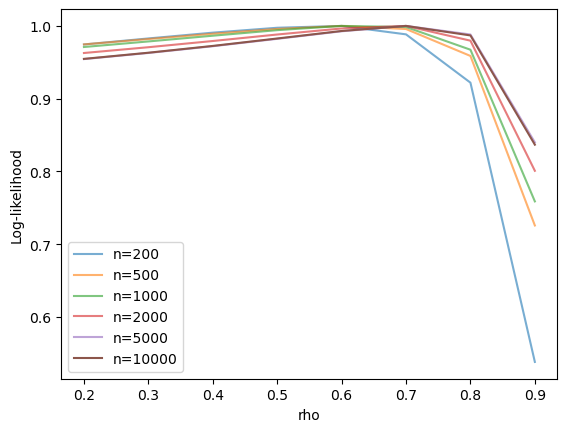

In [69]:
plt.plot(np.arange(0.2,1.,0.1),list_ll_200[4:]/np.max(list_ll_200),label='n=200',alpha=.6)
plt.plot(np.arange(0.2,1.,0.1),list_ll_500[4:]/np.max(list_ll_500),label='n=500',alpha=.6)
plt.plot(np.arange(0.2,1.,0.1),list_ll_1000[4:]/np.max(list_ll_1000),label='n=1000',alpha=.6)
plt.plot(np.arange(0.2,1.,0.1),list_ll_2000[4:]/np.max(list_ll_2000),label='n=2000',alpha=.6)
plt.plot(np.arange(0.2,1.,0.1),list_ll_5000[4:]/np.max(list_ll_5000),label='n=5000',alpha=.6)
plt.plot(np.arange(0.2,1.,0.1),list_ll_10000[4:]/np.max(list_ll_10000),label='n=10000')
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

In [90]:
list_n_samples = [200, 500, 1000, 2000, 5000]
rho=0.9

list_ll = []

for n_samples in list_n_samples:
    print(n_samples)
    
    X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]

    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples

    list_ll_temp = []
    for rho_temp in np.arange(0.5,.79,0.02):
        mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
        list_ll_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))
    list_ll.append(list_ll_temp)

200
500
1000
2000
5000


In [125]:
%%time
rho=0.9

n_samples = 10000

X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

list_ll_temp = []
for rho_temp in np.arange(0.5,.79,0.02):
    mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
    list_ll_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))
list_ll.append(list_ll_temp)

Wall time: 5min 25s


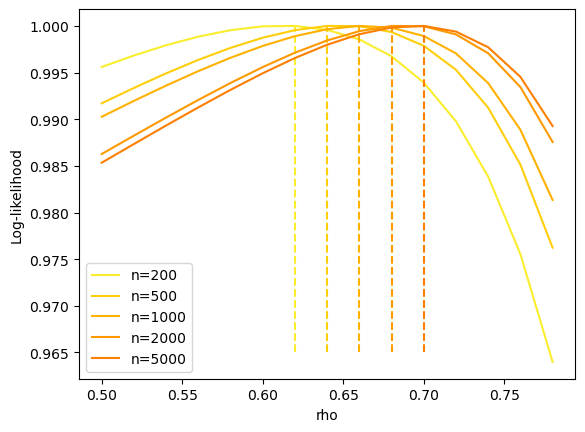

In [109]:
cmap = plt.get_cmap('Wistia')
colors = [cmap(i) for i in np.linspace(0, 1, len(list_ll)+1)]
list_x = np.arange(0.5,.79,0.02)

for i in range(len(list_ll)):
    list_ll_temp = list_ll[i]
    plt.plot(list_x,list_ll_temp/np.max(list_ll_temp),label='n='+str(list_n_samples[i]),color=colors[i+1])
    argmax = np.array(list_ll_temp).argmax()
    plt.plot([list_x[argmax],list_x[argmax]],[0.965,1],'--',color=colors[i+1])
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

In [127]:
list_n_samples = [200, 500, 1000, 2000, 5000, 10000]

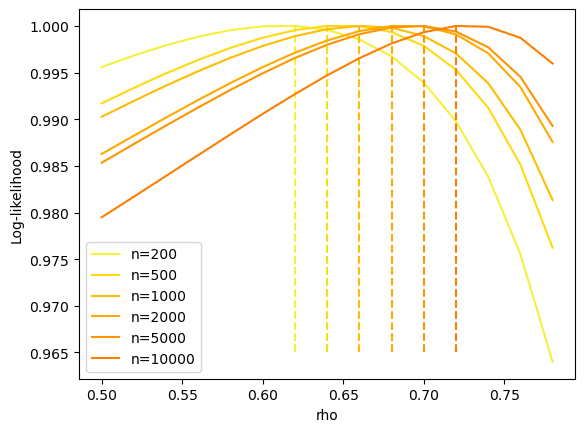

In [129]:
cmap = plt.get_cmap('Wistia')
colors = [cmap(i) for i in np.linspace(0, 1, len(list_ll)+1)]
list_x = np.arange(0.5,.79,0.02)

for i in range(len(list_ll)):
    list_ll_temp = list_ll[i]
    plt.plot(list_x,list_ll_temp/np.max(list_ll_temp),label='n='+str(list_n_samples[i]),color=colors[i+1])
    argmax = np.array(list_ll_temp).argmax()
    plt.plot([list_x[argmax],list_x[argmax]],[0.965,1],'--',color=colors[i+1])
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

## Test of rho=0.1

In [34]:
list_n_samples = [200, 500, 1000, 2000]
rho=0.1

list_x = np.arange(-.1,.11,0.02)

list_ll = []

for n_samples in list_n_samples:
    print(n_samples)
    
    X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]

    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples

    list_ll_temp = []
    for rho_temp in list_x:
        mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
        list_ll_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))
    list_ll.append(list_ll_temp)

200
500
1000
2000


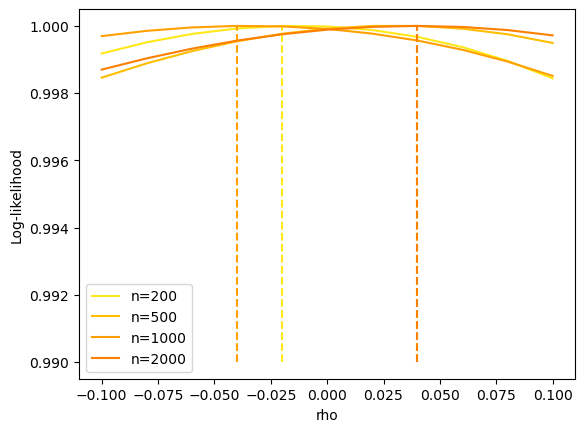

In [35]:
cmap = plt.get_cmap('Wistia')
colors = [cmap(i) for i in np.linspace(0, 1, len(list_ll)+1)]

for i in range(len(list_ll)):
    list_ll_temp = list_ll[i]
    plt.plot(list_x,list_ll_temp/np.max(list_ll_temp),label='n='+str(list_n_samples[i]),color=colors[i+1])
    argmax = np.array(list_ll_temp).argmax()
    plt.plot([list_x[argmax],list_x[argmax]],[0.99,1],'--',color=colors[i+1])
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

## Test of rho=0.5

In [39]:
list_n_samples = [200, 500, 1000, 2000, 5000]
rho=0.5

list_x = np.arange(.12,.31,0.02)

list_ll = []

for n_samples in list_n_samples:
    print(n_samples)
    
    X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]

    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples

    list_ll_temp = []
    for rho_temp in list_x:
        mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
        list_ll_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))
    list_ll.append(list_ll_temp)

200
500
1000
2000
5000


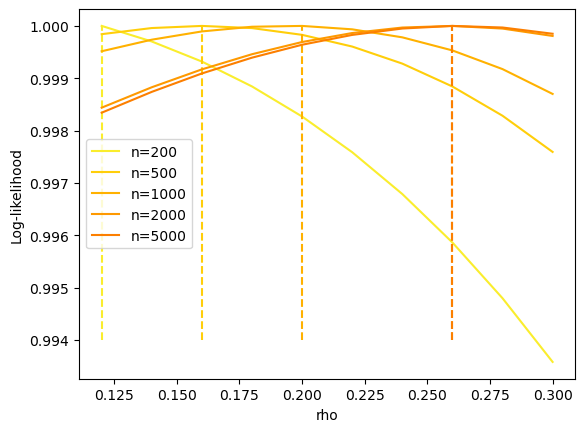

In [41]:
cmap = plt.get_cmap('Wistia')
colors = [cmap(i) for i in np.linspace(0, 1, len(list_ll)+1)]

for i in range(len(list_ll)):
    list_ll_temp = list_ll[i]
    plt.plot(list_x,list_ll_temp/np.max(list_ll_temp),label='n='+str(list_n_samples[i]),color=colors[i+1])
    argmax = np.array(list_ll_temp).argmax()
    plt.plot([list_x[argmax],list_x[argmax]],[0.994,1],'--',color=colors[i+1])
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

## Test of rho=0.7

In [26]:
list_n_samples = [200, 500, 1000, 2000, 5000]
rho=0.7

list_x = np.arange(.3,.51,0.02)

list_ll = []

for n_samples in list_n_samples:
    print(n_samples)
    
    X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]

    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples

    list_ll_temp = []
    for rho_temp in list_x:
        mu_temp = dirichlet_regression.compute_mu_spatial_2(X, beta, rho_temp, W)
        list_ll_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp,phi,Y))
    list_ll.append(list_ll_temp)

200
500
1000
2000
5000


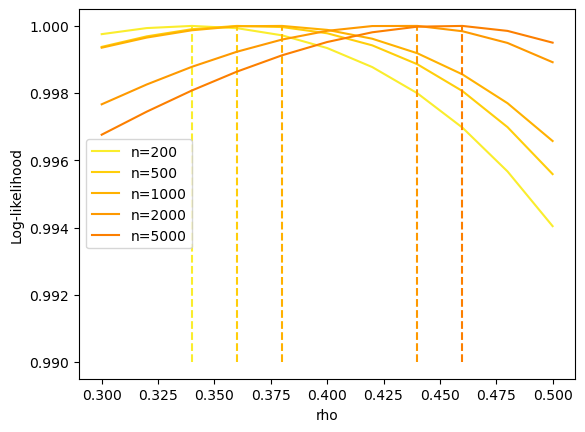

In [27]:
cmap = plt.get_cmap('Wistia')
colors = [cmap(i) for i in np.linspace(0, 1, len(list_ll)+1)]

for i in range(len(list_ll)):
    list_ll_temp = list_ll[i]
    plt.plot(list_x,list_ll_temp/np.max(list_ll_temp),label='n='+str(list_n_samples[i]),color=colors[i+1])
    argmax = np.array(list_ll_temp).argmax()
    plt.plot([list_x[argmax],list_x[argmax]],[0.99,1],'--',color=colors[i+1])
plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

# Some tests on the inverse

In [110]:
X,Z,W = create_features_matrices(500,n_features,choice_W='random',nneighbors=5)
M = np.identity(500) - rho*W

In [111]:
MinvX = np.matmul(np.linalg.inv(M),X)

In [112]:
MinvX

array([[10.        ,  4.6125796 ,  6.70047159],
       [10.        ,  4.24478744,  7.07049746],
       [10.        ,  4.46084048,  6.80166235],
       ...,
       [10.        ,  5.91621152,  5.5357125 ],
       [10.        ,  5.93609863,  5.70249387],
       [10.        ,  5.43869568,  5.17778634]])

In [124]:
1/np.linalg.det(M) * np.conj(M).T

array([[ 5.19446903e+42, -1.16875553e+42, -1.16875553e+42, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.16875553e+42,  5.19446903e+42, -1.16875553e+42, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.16875553e+42, -1.16875553e+42,  5.19446903e+42, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.19446903e+42, -1.16875553e+42, -1.16875553e+42],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16875553e+42,  5.19446903e+42, -1.16875553e+42],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16875553e+42, -1.16875553e+42,  5.19446903e+42]])

In [119]:
np.log(1/np.linalg.det(M)) * X

array([[98.35616832, 52.36462277, 42.26449219],
       [98.35616832,  8.05070393, 86.84754242],
       [98.35616832, 34.08213617, 54.45659225],
       ...,
       [98.35616832, 78.33271588, 57.86316052],
       [98.35616832, 80.72884036, 77.95803226],
       [98.35616832, 20.79859627, 14.73796032]])

## Comparison of AIC

In [ ]:
list_solutions_spatial_rho01 = np.load('Data Dirichlet/spatial_rho01_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho01 = np.load('Data Dirichlet/no_spatial_rho01_2.npy',allow_pickle=True)

list_solutions_spatial_rho05 = np.load('Data Dirichlet/spatial_rho05_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho05 = np.load('Data Dirichlet/no_spatial_rho05_2.npy',allow_pickle=True)

list_solutions_spatial_rho09 = np.load('Data Dirichlet/spatial_rho09_2.npy',allow_pickle=True)
list_solutions_no_spatial_rho09 = np.load('Data Dirichlet/no_spatial_rho09_2.npy',allow_pickle=True)

In [33]:
%%time
rho=0.1

n_repeat = 100

list_aic_spatial_rho01 = []
list_aic_no_spatial_rho01 = []

list_n_samples = [50,200,1000]

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    n_samples = list_n_samples[n_samples_index]
    aic_spatial_temp = []
    aic_no_spatial_temp = []
    for i in range(len(list_solutions_spatial_rho01[n_samples_index])):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples
            
            solution_spatial = list_solutions_spatial_rho01[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            aic_spatial_temp.append(2*9-2*dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            
            solution_no_spatial = list_solutions_no_spatial_rho01[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            aic_no_spatial_temp.append(2*8-2*dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))

            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_aic_spatial_rho01.append(aic_spatial_temp)
    list_aic_no_spatial_rho01.append(aic_no_spatial_temp)
    

Wall time: 20.7 s


In [34]:
np.mean(list_aic_spatial_rho01[0])

-151.72145684834342

In [35]:
np.mean(list_aic_no_spatial_rho01[0])

-152.93276192562405

In [36]:
np.mean(list_aic_spatial_rho01[2])

-5414.971219468767

In [37]:
np.mean(list_aic_no_spatial_rho01[2])

-5415.054768346757

In [38]:
ttest_ind(list_aic_spatial_rho01[2],list_aic_no_spatial_rho01[2])

Ttest_indResult(statistic=0.004103694152704142, pvalue=0.9967298665761838)

In [43]:
%%time
rho=0.5

n_repeat = 100

list_aic_spatial_rho05 = []
list_aic_no_spatial_rho05 = []

list_n_samples = [50,200,1000]

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    n_samples = list_n_samples[n_samples_index]
    aic_spatial_temp = []
    aic_no_spatial_temp = []
    for i in range(len(list_solutions_spatial_rho05[n_samples_index])):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,choice_W='random',nneighbors=5)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples
            
            solution_spatial = list_solutions_spatial_rho05[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            aic_spatial_temp.append(2*9-2*dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            
            solution_no_spatial = list_solutions_no_spatial_rho05[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            aic_no_spatial_temp.append(2*8-2*dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))

            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_aic_spatial_rho05.append(aic_spatial_temp)
    list_aic_no_spatial_rho05.append(aic_no_spatial_temp)
    

Wall time: 20.5 s


In [44]:
print(np.mean(list_aic_spatial_rho05[0]))
print(np.mean(list_aic_no_spatial_rho05[0]))

-161.95074187402517
-162.20679817888652


In [45]:
print(np.mean(list_aic_spatial_rho05[2]))
print(np.mean(list_aic_no_spatial_rho05[2]))

-5842.106371158382
-5815.516639743361


In [46]:
ttest_ind(list_aic_spatial_rho05[2],list_aic_no_spatial_rho05[2])

Ttest_indResult(statistic=-1.0885281570657483, pvalue=0.27768517251705943)

## Comparison of scores

In [46]:
%%time

rho=0.9

r2_scores_rho09_s, r2_scores_rho09_ns = [], []
rmse_scores_rho09_s, rmse_scores_rho09_ns = [], []
crossentropy_scores_rho09_s, crossentropy_scores_rho09_ns = [], []
aic_scores_rho09_s, aic_scores_rho09_ns = [], []
ll_scores_rho09_s, ll_scores_rho09_ns = [], []

for i in range(100):
    X,Z,W = create_features_matrices(1000,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]
    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples
    
    beta_sol_s = list_solutions_spatial_rho09[2,i][:9].reshape((3,3))
    gamma_sol_s = list_solutions_spatial_rho09[2,i][9:-1]
    phi_sol_s = np.exp(np.matmul(Z,gamma_sol_s))
    rho_sol_s = list_solutions_spatial_rho09[2,i][-1]

    beta_sol_ns = list_solutions_no_spatial_rho09[2,i][:9].reshape((3,3))
    gamma_sol_ns = list_solutions_no_spatial_rho09[2,i][9:]
    phi_sol_ns = np.exp(np.matmul(Z,gamma_sol_ns))
    
    mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
    mu_sol_ns = dirichlet_regression.compute_mu_2(X, beta_sol_ns)
    
    r2_scores_rho09_s.append(r2_score(mu,mu_sol_s))
    r2_scores_rho09_ns.append(r2_score(mu,mu_sol_ns))
    rmse_scores_rho09_s.append(mean_squared_error(mu,mu_sol_s,squared=False))
    rmse_scores_rho09_ns.append(mean_squared_error(mu,mu_sol_ns,squared=False))
    crossentropy_scores_rho09_s.append(-(1/1000)*np.sum(mu*np.log(mu_sol_s)))
    crossentropy_scores_rho09_ns.append(-(1/1000)*np.sum(mu*np.log(mu_sol_ns)))
    ll_s = dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_sol_s,Y)
    ll_ns = dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_sol_ns,Y)
    ll_scores_rho09_s.append(2*9-2*ll_s)
    ll_scores_rho09_ns.append(2*8-2*ll_ns)
    aic_scores_rho09_s.append(2*9-2*ll_s)
    aic_scores_rho09_ns.append(2*8-2*ll_ns)

Wall time: 23.8 s


In [44]:
%%time

rho=0.5

r2_scores_rho05_s, r2_scores_rho05_ns = [], []
rmse_scores_rho05_s, rmse_scores_rho05_ns = [], []
crossentropy_scores_rho05_s, crossentropy_scores_rho05_ns = [], []
aic_scores_rho05_s, aic_scores_rho05_ns = [], []
ll_scores_rho05_s, ll_scores_rho05_ns = [], []

for i in range(100):
    X,Z,W = create_features_matrices(1000,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]
    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples
    
    beta_sol_s = list_solutions_spatial_rho05[2,i][:9].reshape((3,3))
    gamma_sol_s = list_solutions_spatial_rho05[2,i][9:-1]
    phi_sol_s = np.exp(np.matmul(Z,gamma_sol_s))
    rho_sol_s = list_solutions_spatial_rho05[2,i][-1]

    beta_sol_ns = list_solutions_no_spatial_rho05[2,i][:9].reshape((3,3))
    gamma_sol_ns = list_solutions_no_spatial_rho05[2,i][9:]
    phi_sol_ns = np.exp(np.matmul(Z,gamma_sol_ns))
    
    mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
    mu_sol_ns = dirichlet_regression.compute_mu_2(X, beta_sol_ns)
    
    r2_scores_rho05_s.append(r2_score(mu,mu_sol_s))
    r2_scores_rho05_ns.append(r2_score(mu,mu_sol_ns))
    rmse_scores_rho05_s.append(mean_squared_error(mu,mu_sol_s,squared=False))
    rmse_scores_rho05_ns.append(mean_squared_error(mu,mu_sol_ns,squared=False))
    crossentropy_scores_rho05_s.append(-(1/1000)*np.sum(mu*np.log(mu_sol_s)))
    crossentropy_scores_rho05_ns.append(-(1/1000)*np.sum(mu*np.log(mu_sol_ns)))
    ll_s = dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_sol_s,Y)
    ll_ns = dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_sol_ns,Y)
    ll_scores_rho05_s.append(2*9-2*ll_s)
    ll_scores_rho05_ns.append(2*8-2*ll_ns)
    aic_scores_rho05_s.append(2*9-2*ll_s)
    aic_scores_rho05_ns.append(2*8-2*ll_ns)

Wall time: 21.9 s


In [32]:
%%time

rho=0.1

r2_scores_rho01_s, r2_scores_rho01_ns = [], []
rmse_scores_rho01_s, rmse_scores_rho01_ns = [], []
crossentropy_scores_rho01_s, crossentropy_scores_rho01_ns = [], []
aic_scores_rho01_s, aic_scores_rho01_ns = [], []
ll_scores_rho01_s, ll_scores_rho01_ns = [], []

for i in range(100):
    X,Z,W = create_features_matrices(1000,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]
    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples
    
    beta_sol_s = list_solutions_spatial_rho01[2,i][:9].reshape((3,3))
    gamma_sol_s = list_solutions_spatial_rho01[2,i][9:-1]
    phi_sol_s = np.exp(np.matmul(Z,gamma_sol_s))
    rho_sol_s = list_solutions_spatial_rho01[2,i][-1]

    beta_sol_ns = list_solutions_no_spatial_rho01[2,i][:9].reshape((3,3))
    gamma_sol_ns = list_solutions_no_spatial_rho01[2,i][9:]
    phi_sol_ns = np.exp(np.matmul(Z,gamma_sol_ns))
    
    mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
    mu_sol_ns = dirichlet_regression.compute_mu_2(X, beta_sol_ns)
    
    r2_scores_rho01_s.append(r2_score(mu,mu_sol_s))
    r2_scores_rho01_ns.append(r2_score(mu,mu_sol_ns))
    rmse_scores_rho01_s.append(mean_squared_error(mu,mu_sol_s,squared=False))
    rmse_scores_rho01_ns.append(mean_squared_error(mu,mu_sol_ns,squared=False))
    crossentropy_scores_rho01_s.append(-(1/1000)*np.sum(mu*np.log(mu_sol_s)))
    crossentropy_scores_rho01_ns.append(-(1/1000)*np.sum(mu*np.log(mu_sol_ns)))
    ll_s = dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_sol_s,Y)
    ll_ns = dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_sol_ns,Y)
    ll_scores_rho01_s.append(2*9-2*ll_s)
    ll_scores_rho01_ns.append(2*8-2*ll_ns)
    aic_scores_rho01_s.append(2*9-2*ll_s)
    aic_scores_rho01_ns.append(2*8-2*ll_ns)

Wall time: 19.5 s


In [25]:
%%time

rho=0.

r2_scores_rho00_s, r2_scores_rho00_ns = [], []
rmse_scores_rho00_s, rmse_scores_rho00_ns = [], []
crossentropy_scores_rho00_s, crossentropy_scores_rho00_ns = [], []
aic_scores_rho00_s, aic_scores_rho00_ns = [], []
ll_scores_rho00_s, ll_scores_rho00_ns = [], []

for i in range(100):
    X,Z,W = create_features_matrices(1000,n_features,choice_W='random',nneighbors=5)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]
    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    Y = (Y*(n_samples-1)+1/n_classes)/n_samples
    
    beta_sol_s = list_solutions_spatial_rho00[2,i][:9].reshape((3,3))
    gamma_sol_s = list_solutions_spatial_rho00[2,i][9:-1]
    phi_sol_s = np.exp(np.matmul(Z,gamma_sol_s))
    rho_sol_s = list_solutions_spatial_rho00[2,i][-1]

    beta_sol_ns = list_solutions_no_spatial_rho00[2,i][:9].reshape((3,3))
    gamma_sol_ns = list_solutions_no_spatial_rho00[2,i][9:]
    phi_sol_ns = np.exp(np.matmul(Z,gamma_sol_ns))
    
    mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
    mu_sol_ns = dirichlet_regression.compute_mu_2(X, beta_sol_ns)
    
    r2_scores_rho00_s.append(r2_score(mu,mu_sol_s))
    r2_scores_rho00_ns.append(r2_score(mu,mu_sol_ns))
    rmse_scores_rho00_s.append(mean_squared_error(mu,mu_sol_s,squared=False))
    rmse_scores_rho00_ns.append(mean_squared_error(mu,mu_sol_ns,squared=False))
    crossentropy_scores_rho00_s.append(-(1/1000)*np.sum(mu*np.log(mu_sol_s)))
    crossentropy_scores_rho00_ns.append(-(1/1000)*np.sum(mu*np.log(mu_sol_ns)))
    ll_s = dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_sol_s,Y)
    ll_ns = dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_sol_ns,Y)
    ll_scores_rho00_s.append(2*9-2*ll_s)
    ll_scores_rho00_ns.append(2*8-2*ll_ns)
    aic_scores_rho00_s.append(2*9-2*ll_s)
    aic_scores_rho00_ns.append(2*8-2*ll_ns)

Wall time: 21.7 s


In [26]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = 'Scores on test set (with the parameters estimated with n=1000)'

pt.add_row(['No spatial (rho=0)', 
            str(np.round(np.mean(crossentropy_scores_rho00_ns),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho00_ns),3)) +')',
            str(np.round(np.mean(aic_scores_rho00_ns),3))+' ('+ str(np.round(np.std(aic_scores_rho00_ns),3)) +')',
            str(np.round(np.mean(rmse_scores_rho00_ns),3))+' ('+ str(np.round(np.std(rmse_scores_rho00_ns),3)) +')',
            str(np.round(np.mean(r2_scores_rho00_ns),3))+' ('+ str(np.round(np.std(r2_scores_rho00_ns),3)) +')',
           ])

pt.add_row(['Spatial (rho=0)', 
            str(np.round(np.mean(crossentropy_scores_rho00_s),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho00_s),3)) +')',
            str(np.round(np.mean(aic_scores_rho00_s),3))+' ('+ str(np.round(np.std(aic_scores_rho00_s),3)) +')',
            str(np.round(np.mean(rmse_scores_rho00_s),3))+' ('+ str(np.round(np.std(rmse_scores_rho00_s),3)) +')',
            str(np.round(np.mean(r2_scores_rho00_s),3))+' ('+ str(np.round(np.std(r2_scores_rho00_s),3)) +')',
           ])

print(pt)

+------------------------------------------------------------------------------------------+
|              Scores on test set (with the parameters estimated with n=1000)              |
+--------------------+---------------+---------------------+---------------+---------------+
|       Model        | Cross-entropy |         AIC         |      RMSE     |       R2      |
+--------------------+---------------+---------------------+---------------+---------------+
| No spatial (rho=0) | 1.011 (0.004) | -5400.215 (155.656) | 0.036 (0.003) | 0.875 (0.025) |
|  Spatial (rho=0)   | 1.011 (0.004) |  -5397.718 (155.58) | 0.036 (0.003) | 0.874 (0.025) |
+--------------------+---------------+---------------------+---------------+---------------+


In [72]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = 'Scores on test set (with the parameters estimated with n=1000)'

pt.add_row(['No spatial (rho=0.1)', 
            str(np.round(np.mean(crossentropy_scores_rho01_ns),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho01_ns),3)) +')',
            str(np.round(np.mean(aic_scores_rho01_ns),3))+' ('+ str(np.round(np.std(aic_scores_rho01_ns),3)) +')',
            str(np.round(np.mean(rmse_scores_rho01_ns),3))+' ('+ str(np.round(np.std(rmse_scores_rho01_ns),3)) +')',
            str(np.round(np.mean(r2_scores_rho01_ns),3))+' ('+ str(np.round(np.std(r2_scores_rho01_ns),3)) +')',
           ])

pt.add_row(['Spatial (rho=0.1)', 
            str(np.round(np.mean(crossentropy_scores_rho01_s),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho01_s),3)) +')',
            str(np.round(np.mean(aic_scores_rho01_s),3))+' ('+ str(np.round(np.std(aic_scores_rho01_s),3)) +')',
            str(np.round(np.mean(rmse_scores_rho01_s),3))+' ('+ str(np.round(np.std(rmse_scores_rho01_s),3)) +')',
            str(np.round(np.mean(r2_scores_rho01_s),3))+' ('+ str(np.round(np.std(r2_scores_rho01_s),3)) +')',
           ])

pt.add_row(['No spatial (rho=0.5)', 
            str(np.round(np.mean(crossentropy_scores_rho05_ns),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho05_ns),3)) +')',
            str(np.round(np.mean(aic_scores_rho05_ns),3))+' ('+ str(np.round(np.std(aic_scores_rho05_ns),3)) +')',
            str(np.round(np.mean(rmse_scores_rho05_ns),3))+' ('+ str(np.round(np.std(rmse_scores_rho05_ns),3)) +')',
            str(np.round(np.mean(r2_scores_rho05_ns),3))+' ('+ str(np.round(np.std(r2_scores_rho05_ns),3)) +')',
           ])

pt.add_row(['Spatial (rho=0.5)', 
            str(np.round(np.mean(crossentropy_scores_rho05_s),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho05_s),3)) +')',
            str(np.round(np.mean(aic_scores_rho05_s),3))+' ('+ str(np.round(np.std(aic_scores_rho05_s),3)) +')',
            str(np.round(np.mean(rmse_scores_rho05_s),3))+' ('+ str(np.round(np.std(rmse_scores_rho05_s),3)) +')',
            str(np.round(np.mean(r2_scores_rho05_s),3))+' ('+ str(np.round(np.std(r2_scores_rho05_s),3)) +')',
           ])

pt.add_row(['No spatial (rho=0.9)', 
            str(np.round(np.mean(crossentropy_scores_rho09_ns),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho09_ns),3)) +')',
            str(np.round(np.mean(aic_scores_rho09_ns),3))+' ('+ str(np.round(np.std(aic_scores_rho09_ns),3)) +')',
            str(np.round(np.mean(rmse_scores_rho09_ns),3))+' ('+ str(np.round(np.std(rmse_scores_rho09_ns),3)) +')',
            str(np.round(np.mean(r2_scores_rho09_ns),3))+' ('+ str(np.round(np.std(r2_scores_rho09_ns),3)) +')',
           ])

pt.add_row(['Spatial (rho=0.9)', 
            str(np.round(np.mean(crossentropy_scores_rho09_s),3))+' ('+ str(np.round(np.std(crossentropy_scores_rho09_s),3)) +')',
            str(np.round(np.mean(aic_scores_rho09_s),3))+' ('+ str(np.round(np.std(aic_scores_rho09_s),3)) +')',
            str(np.round(np.mean(rmse_scores_rho09_s),3))+' ('+ str(np.round(np.std(rmse_scores_rho09_s),3)) +')',
            str(np.round(np.mean(r2_scores_rho09_s),3))+' ('+ str(np.round(np.std(r2_scores_rho09_s),3)) +')',
           ])

print(pt)

+--------------------------------------------------------------------------------------------+
|               Scores on test set (with the parameters estimated with n=1000)               |
+----------------------+---------------+---------------------+---------------+---------------+
|        Model         | Cross-entropy |         AIC         |      RMSE     |       R2      |
+----------------------+---------------+---------------------+---------------+---------------+
| No spatial (rho=0.1) | 1.011 (0.004) | -4303.912 (126.062) | 0.037 (0.003) | 0.872 (0.027) |
|  Spatial (rho=0.1)   | 1.011 (0.004) |  -4302.02 (125.892) | 0.037 (0.003) | 0.873 (0.027) |
| No spatial (rho=0.5) | 0.997 (0.005) | -4560.714 (132.384) | 0.063 (0.003) | 0.766 (0.019) |
|  Spatial (rho=0.5)   |  0.99 (0.007) | -4585.442 (133.447) | 0.051 (0.008) |  0.83 (0.051) |
| No spatial (rho=0.9) |  0.91 (0.015) | -7126.082 (225.689) |  0.2 (0.008)  | 0.164 (0.059) |
|  Spatial (rho=0.9)   | 0.886 (0.033) |  -7171.69

In [47]:
list_lrt_rho00 = 2*(np.array(ll_scores_rho00_ns)-np.array(ll_scores_rho00_s))
list_lrt_rho01 = 2*(np.array(ll_scores_rho01_ns)-np.array(ll_scores_rho01_s))
list_lrt_rho05 = 2*(np.array(ll_scores_rho05_ns)-np.array(ll_scores_rho05_s))
list_lrt_rho09 = 2*(np.array(ll_scores_rho09_ns)-np.array(ll_scores_rho09_s))

In [52]:
np.sum(list_lrt_rho00**2<1.96**2)

7

In [53]:
np.sum(list_lrt_rho01**2<1.96**2)

25

In [54]:
np.sum(list_lrt_rho05**2<1.96**2)

1

In [55]:
np.sum(list_lrt_rho09**2<1.96**2)

2

# OLD

In [ ]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.1]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho01[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho01[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho01[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho01[i],axis=0))

In [22]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.603    |    0.541     |     0.476     |   0.164    |    0.034    |    0.006     |   0.528    |    0.327    |    0.233     |
|   beta02   |    -0.465   |    -0.423    |     -0.324    |   0.169    |    0.047    |    0.009     |   0.385    |    0.226    |    0.11

In [23]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.1, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.1, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.575    |    0.531     |     0.476     |   0.158    |    0.033    |    0.007     |   0.488    |    0.315    |    0.234     |
|   beta02   |    -0.419   |    -0.428    |     -0.336    |   0.146    |    0.049    |    0.009     |   0.321    |    0.233    |    0.12

In [24]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.5]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho05[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho05[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho05[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho05[i],axis=0))

In [25]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.5, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.5, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.567    |    0.544     |     0.479     |   0.158    |    0.029    |    0.008     |    0.48    |    0.324    |    0.238     |
|   beta02   |    -0.57    |    -0.494    |     -0.461    |   0.155    |    0.029    |    0.006     |   0.479    |    0.274    |    0.21

In [26]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.5, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.5, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.519    |    0.486     |     0.379     |   0.158    |    0.038    |    0.008     |   0.428    |    0.274    |    0.152     |
|   beta02   |    -0.61    |    -0.582    |     -0.568    |   0.178    |     0.05    |     0.01     |   0.551    |    0.389    |    0.33

In [27]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.9]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho09[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho09[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho09[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho09[i],axis=0))

In [28]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.9, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.9, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.407    |    0.335     |      0.1      |    0.19    |    0.133    |    0.062     |   0.356    |    0.246    |    0.071     |
|   beta02   |    -1.158   |    -1.214    |     -1.226    |   0.228    |    0.063    |     0.02     |   1.569    |    1.537    |    1.52

In [29]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.9, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.9, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |     0.27    |     0.22     |     0.058     |   0.277    |    0.068    |    0.016     |   0.349    |    0.116    |    0.019     |
|   beta02   |    -1.71    |    -1.882    |     -1.924    |   0.384    |    0.071    |    0.019     |   3.307    |    3.614    |    3.72

# Table of the metrics

In [77]:
list_rhos = [0.1, 0.5, 0.9]
list_n = [50, 200, 1000]

## rho=0.1

In [78]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.1)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho01[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho01[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho01[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho01[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho01[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho01[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho01[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho01[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho01[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho01[i]),3)) +')'])

print(pt)

+-----------------------------------------------------------------------------------------+
|                                         (rho=0.1)                                       |
+---------------------+---------------+-------------------+---------------+---------------+
|        Model        | Cross-entropy |        AIC        |      RMSE     |       R2      |
+---------------------+---------------+-------------------+---------------+---------------+
|    Spatial (n=50)   | 1.028 (0.014) | -4994.8 (100.916) | 0.331 (0.005) | 0.109 (0.025) |
|   Spatial (n=200)   | 1.018 (0.009) |  -5317.2 (66.254) | 0.327 (0.004) | 0.129 (0.013) |
|   Spatial (n=1000)  |  1.01 (0.007) |  -5430.0 (76.777) | 0.325 (0.003) |  0.14 (0.01)  |
|  No spatial (n=50)  | 1.024 (0.011) |  -5041.8 (89.967) |  0.33 (0.004) | 0.115 (0.019) |
|  No spatial (n=200) | 1.017 (0.008) |  -5323.8 (65.808) | 0.327 (0.004) | 0.129 (0.013) |
| No spatial (n=1000) |  1.01 (0.007) |  -5431.4 (76.951) | 0.325 (0.003) |  0.1

### Are the differences significant ?

In [79]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho01[i],list_crossentropy_ns_rho01[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho01[i]),2*7-2*np.array(list_ll_ns_rho01[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho01[i],list_rmse_ns_rho01[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho01[i],list_r2_ns_rho01[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.8883313425706156, pvalue=0.0604437191613186)
n = 200 : Ttest_indResult(statistic=0.31282835019075794, pvalue=0.7547403214236674)
n = 1000 : Ttest_indResult(statistic=-0.254462172921865, pvalue=0.7994026045067513)
AIC:
n = 50 : Ttest_indResult(statistic=1.7335995553184993, pvalue=0.08454582762864397)
n = 200 : Ttest_indResult(statistic=0.35366896428195777, pvalue=0.7239632806203458)
n = 1000 : Ttest_indResult(statistic=0.06276133030747345, pvalue=0.9500198705308842)
RMSE:
n = 50 : Ttest_indResult(statistic=1.6467369054312777, pvalue=0.10119835261620479)
n = 200 : Ttest_indResult(statistic=0.27912025875952384, pvalue=0.7804438615566557)
n = 1000 : Ttest_indResult(statistic=-0.1928214295511216, pvalue=0.8472964567073328)
R2:
n = 50 : Ttest_indResult(statistic=-1.9338188535051086, pvalue=0.054561094004819406)
n = 200 : Ttest_indResult(statistic=-0.3897448950668636, pvalue=0.6971440982448002)
n = 1000 : Ttest_indResult(statistic=0.286876421

## rho=0.5

In [80]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.5)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho05[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho05[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho05[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho05[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho05[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho05[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho05[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho05[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho05[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho05[i]),3)) +')'])

print(pt)

+-----------------------------------------------------------------------------------------+
|                                         (rho=0.5)                                       |
+---------------------+---------------+-------------------+---------------+---------------+
|        Model        | Cross-entropy |        AIC        |      RMSE     |       R2      |
+---------------------+---------------+-------------------+---------------+---------------+
|    Spatial (n=50)   | 1.029 (0.016) | -4970.4 (117.314) | 0.331 (0.006) | 0.106 (0.026) |
|   Spatial (n=200)   | 1.018 (0.009) |  -5294.8 (67.744) | 0.328 (0.004) | 0.126 (0.015) |
|   Spatial (n=1000)  | 1.012 (0.007) |  -5392.2 (75.369) | 0.326 (0.003) | 0.135 (0.011) |
|  No spatial (n=50)  | 1.026 (0.012) | -5034.2 (100.792) |  0.33 (0.005) | 0.111 (0.021) |
|  No spatial (n=200) | 1.017 (0.009) |  -5324.4 (67.499) | 0.327 (0.004) | 0.129 (0.015) |
| No spatial (n=1000) | 1.011 (0.007) |  -5415.2 (76.665) | 0.326 (0.003) |  0.1

### Are the differences significant ?

In [81]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho05[i],list_crossentropy_ns_rho05[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho05[i]),2*7-2*np.array(list_ll_ns_rho05[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho05[i],list_rmse_ns_rho05[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho05[i],list_r2_ns_rho05[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.5691376468405764, pvalue=0.11821256938544869)
n = 200 : Ttest_indResult(statistic=1.4336899190589059, pvalue=0.15323803535847438)
n = 1000 : Ttest_indResult(statistic=1.6336619814124052, pvalue=0.10391890659880461)
AIC:
n = 50 : Ttest_indResult(statistic=2.052352759842644, pvalue=0.041451023468424796)
n = 200 : Ttest_indResult(statistic=1.545668196532367, pvalue=0.12378151942823583)
n = 1000 : Ttest_indResult(statistic=1.0644547997050315, pvalue=0.28841910583388874)
RMSE:
n = 50 : Ttest_indResult(statistic=1.2883272844686482, pvalue=0.19913551071845548)
n = 200 : Ttest_indResult(statistic=1.1524038869274207, pvalue=0.250544591661697)
n = 1000 : Ttest_indResult(statistic=1.2469897529384346, pvalue=0.21387430444952396)
R2:
n = 50 : Ttest_indResult(statistic=-1.5539602548487252, pvalue=0.12179082559334745)
n = 200 : Ttest_indResult(statistic=-1.5000634958683126, pvalue=0.13519079599547476)
n = 1000 : Ttest_indResult(statistic=-1.875744143

## rho=0.9

In [82]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.9)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho09[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho09[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho09[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho09[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho09[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho09[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho09[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho09[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho09[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho09[i]),3)) +')'])

print(pt)

+------------------------------------------------------------------------------------------+
|                                         (rho=0.9)                                        |
+---------------------+---------------+-------------------+---------------+----------------+
|        Model        | Cross-entropy |        AIC        |      RMSE     |       R2       |
+---------------------+---------------+-------------------+---------------+----------------+
|    Spatial (n=50)   | 1.101 (0.067) | -4290.0 (630.573) | 0.353 (0.018) | -0.021 (0.105) |
|   Spatial (n=200)   | 1.074 (0.036) | -4878.6 (146.808) | 0.346 (0.011) |  0.025 (0.06)  |
|   Spatial (n=1000)  | 1.055 (0.017) |  -5024.4 (91.884) | 0.341 (0.006) | 0.054 (0.025)  |
|  No spatial (n=50)  | 1.086 (0.056) | -4628.2 (536.501) | 0.349 (0.015) | 0.003 (0.086)  |
|  No spatial (n=200) | 1.074 (0.023) |  -5005.0 (98.687) | 0.345 (0.007) | 0.028 (0.034)  |
| No spatial (n=1000) | 1.069 (0.014) |  -5007.0 (80.837) | 0.344 (0.0

### Are the differences significant ?

In [83]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho09[i],list_crossentropy_ns_rho09[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho09[i]),2*7-2*np.array(list_ll_ns_rho09[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho09[i],list_rmse_ns_rho09[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho09[i],list_r2_ns_rho09[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.7558047152040044, pvalue=0.08066801238410436)
n = 200 : Ttest_indResult(statistic=0.03449104215518416, pvalue=0.9725203312797396)
n = 1000 : Ttest_indResult(statistic=-6.184063468481065, pvalue=3.5095154425593113e-09)
AIC:
n = 50 : Ttest_indResult(statistic=2.0324306468808233, pvalue=0.04344551189172507)
n = 200 : Ttest_indResult(statistic=3.556834363119982, pvalue=0.00046962541579240397)
n = 1000 : Ttest_indResult(statistic=-0.7054314449655436, pvalue=0.48137086031656795)
RMSE:
n = 50 : Ttest_indResult(statistic=1.6984080313429484, pvalue=0.09100160778672632)
n = 200 : Ttest_indResult(statistic=0.42323760163879215, pvalue=0.672581264982298)
n = 1000 : Ttest_indResult(statistic=-4.965321312984711, pvalue=1.476748501018695e-06)
R2:
n = 50 : Ttest_indResult(statistic=-1.7414834096190575, pvalue=0.08315197813895704)
n = 200 : Ttest_indResult(statistic=-0.33824762455290536, pvalue=0.7355349739888672)
n = 1000 : Ttest_indResult(statistic=6.